# 词性标注 POS
POS是Part-of-Speech tagging，意思是"词性标注"
> 词性标注（Part-of-Speech tagging 或POS tagging)，又称词类标注或者简称标注，是指为分词结果中的每个单词标注一个正确的词性的程序，也即确定每个词是名词、动词、形容词或其他词性的过程。
更多：http://www.hankcs.com/nlp/part-of-speech-tagging.html

本主主要讲述如果利用双向GRU+CRF实现词性标注(GRU是LSTM的变体，LSTM是RNN的一种本体，所以作者叫做[pos_birnn_crf_test](https://nbviewer.jupyter.org/github/zhedongzheng/finch/blob/master/nlp-models/tensorflow/tf-data-api/pos_birnn_crf_test.ipynb))
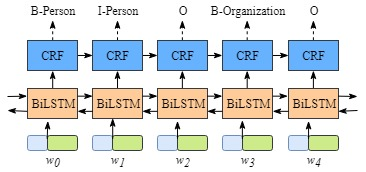

# 加载数据

In [1]:
# pos.py
'''
    pad 填充默认符号
    unk 未知单词默认符号
    word2idx:如{'pad':0,'我们':1,'宠物':2}
    word_idx:代表对应单词的索引，如第一个单词为“我们”=>我们：1
    
    tag2idx和tag_idx类似
'''
def load_data():
    word2idx={'<pad>':0}
    tag2idx={'<pad>':0}
    word_idx=1 
    tag_idx=1
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    
    for line in open('files/data/python74/pos_train.txt'):
        line=line.rstrip() # 去掉末尾换行符
        if line:
            word,tag,_=line.split()
            if word not in word2idx:
                word2idx[word]=word_idx
                word_idx+=1
            x_train.append(word2idx[word])
            
            if tag not in tag2idx:
                tag2idx[tag]=tag_idx
                tag_idx+=1
            y_train.append(tag2idx[tag])
    word2idx['unk']=word_idx
    
    for line in open('files/data/python74/pos_test.txt'):
        line=line.rstrip()
        if line:
            word,tag,_=line.split()
            if word in word2idx:
                x_test.append(word2idx[word])
            else:
                x_test.append(word_idx)
            y_test.append(tag2idx[tag])
    print("词汇数目大小：%d | x_train: %d | x_test: %d" % (len(word2idx),len(x_train),len(x_test)))
    return x_train,y_train,x_test,y_test,len(word2idx),tag_idx,word2idx,tag2idx
_=load_data()


词汇数目大小：19124 | x_train: 211727 | x_test: 47377


# 导入包

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# 参数设置

In [3]:
params={
    'seq_len':20,# 序列长度
    'batch_size':128, # 批处理大小
    'hidden_dim':128, # 隐藏层维度
    'clip_norm':5.0, # 梯度剪切
    'text_iter_step':1,
    'lr':{'start':5e-3,'end':5e-4},# 学习率
    'n_epoch':1,# 训练轮数
    'display_step':50 #每50步输出信息
}
params

{'seq_len': 20,
 'batch_size': 128,
 'hidden_dim': 128,
 'clip_norm': 5.0,
 'text_iter_step': 1,
 'lr': {'start': 0.005, 'end': 0.0005},
 'n_epoch': 1,
 'display_step': 50}

# 数据准备

In [4]:
def to_test_seq(*args):
    return [np.reshape(x[:(len(x)-len(x)%params['seq_len'])],
        [-1,params['seq_len']]) for x in args]
def iter_seq(x):
    return np.array([x[i: i+params['seq_len']] for i in range(
        0, len(x)-params['seq_len'], params['text_iter_step'])])

def to_train_seq(*args):
    return [iter_seq(x) for x in args]

In [5]:
def pipeline_train(X,y,sess):
    dataset=tf.data.Dataset.from_tensor_slices((X,y))
    dataset=dataset.shuffle(len(X)).batch(params['batch_size'])
    iterator=dataset.make_initializable_iterator()
    X_ph=tf.placeholder(tf.int32,[None,params['seq_len']])
    y_ph=tf.placeholder(tf.int32,[None,params['seq_len']])
    init_dict={X_ph:X,y_ph:y}
    sess.run(iterator.initializer,init_dict)
    return iterator,init_dict

def pipeline_test(X,sess):
    dataset=tf.data.Dataset.from_tensor_slices(X)
    dataset=dataset.batch(params['batch_size'])
    iterator=dataset.make_initializable_iterator()
    X_ph=tf.placeholder(tf.int32,[None,params['seq_len']])
    init_dict={X_ph:X}
    sess.run(iterator.initializer,init_dict)
    return iterator,init_dict

x_train,y_train,x_test,y_test,params['vocab_size'],params['n_class'],word2idx,tag2idx=load_data()
X_train, Y_train = to_train_seq(x_train, y_train)
X_test, Y_test = to_test_seq(x_test, y_test)

sess=tf.Session()
params['lr']['steps']=len(X_train)//params['batch_size']
params
iter_train,init_dcit_train=pipeline_train(X_train,Y_train,sess)
iter_test,init_dict_test=pipeline_test(X_test,sess)


词汇数目大小：19124 | x_train: 211727 | x_test: 47377


# 模型

**1.tf.nn.dropout**

tf.nn.dropout是TensorFlow里面为了防止或减轻过拟合而使用的函数，它一般用在全连接层。

Dropout就是在不同的训练过程中随机扔掉一部分神经元。也就是让某个神经元的激活值以一定的概率p，让其停止工作，这次训练过程中不更新权值，也不参加神经网络的计算。但是它的权重得保留下来（只是暂时不更新而已），因为下次样本输入时它可能又得工作了。

**2.tf.layers.dense 全连接层**

tf.layers.dense(

    inputs,
    units,
    activation=None,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer(),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    trainable=True,
    name=None,
    reuse=None
    
)

In [6]:
def rnn_cell():
    return tf.nn.rnn_cell.GRUCell(params['hidden_dim'],
                                  kernel_initializer=tf.orthogonal_initializer()) #生成正交矩阵的随机数

def clip_grads(loss):
    variables=tf.trainable_variables()
    grads=tf.gradients(loss,variables)
    clipped_grads,_=tf.clip_by_global_norm(grads,params['clip_norm']) # 修正梯度值 防止梯度爆炸
    return zip(clipped_grads,variables)

def forward(x,reuse,is_training):
    with tf.variable_scope('model',reuse=reuse):
        x=tf.contrib.layers.embed_sequence(x,params['vocab_size'],params['hidden_dim'])
        x=tf.layers.dropout(x,0.1,training=is_training)
        
        bi_outputs,_=tf.nn.bidirectional_dynamic_rnn(rnn_cell(),rnn_cell(),x,dtype=tf.float32)
        x=tf.concat(bi_outputs,-1)
        logits=tf.layers.dense(x,params['n_class'])
    return logits

In [7]:
ops={}
X_train_batch,y_train_batch=iter_train.get_next()
X_test_batch=iter_test.get_next()

logits_tr=forward(X_train_batch,reuse=False,is_training=True)
logits_te=forward(X_test_batch,reuse=True,is_training=False)

log_likelihood,trans_params=tf.contrib.crf.crf_log_likelihood(
    logits_tr,y_train_batch,tf.count_nonzero(X_train_batch,1))

# 损失
ops['loss']=tf.reduce_mean(-log_likelihood)

ops['global_step']=tf.Variable(0,trainable=False)

# 学习率
ops['lr']=tf.train.exponential_decay(
    params['lr']['start'], ops['global_step'], params['lr']['steps'],
    params['lr']['end']/params['lr']['start'])
# 训练
ops['train']=tf.train.AdamOptimizer(ops['lr']).apply_gradients(
    clip_grads(ops['loss']), global_step=ops['global_step'])

ops['crf_decode'] = tf.contrib.crf.crf_decode(
    logits_te, trans_params, tf.count_nonzero(X_test_batch, 1))[0]

E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [8]:
sess.run(tf.global_variables_initializer())
for epoch in range(1, params['n_epoch']+1):
    while True:
        try:
            _, step, loss, lr = sess.run([ops['train'],
                                          ops['global_step'],
                                          ops['loss'],
                                          ops['lr']])
        except tf.errors.OutOfRangeError:
            break
        else:
            if step % params['display_step'] == 0 or step == 1:
                print("Epoch %d | Step %d | Loss %.3f | LR: %.4f" % (epoch, step, loss, lr))
    
    Y_pred = []
    while True:
        try:
            Y_pred.append(sess.run(ops['crf_decode']))
        except tf.errors.OutOfRangeError:
            break
    Y_pred = np.concatenate(Y_pred)
    
    if epoch != params['n_epoch']:
        sess.run(iter_train.initializer, init_dict_train)
        sess.run(iter_test.initializer, init_dict_test)

Epoch 1 | Step 1 | Loss 75.960 | LR: 0.0050
Epoch 1 | Step 50 | Loss 5.562 | LR: 0.0047
Epoch 1 | Step 100 | Loss 1.532 | LR: 0.0044
Epoch 1 | Step 150 | Loss 1.052 | LR: 0.0041
Epoch 1 | Step 200 | Loss 0.838 | LR: 0.0038
Epoch 1 | Step 250 | Loss 0.556 | LR: 0.0035
Epoch 1 | Step 300 | Loss 0.378 | LR: 0.0033
Epoch 1 | Step 350 | Loss 0.464 | LR: 0.0031
Epoch 1 | Step 400 | Loss 0.310 | LR: 0.0029
Epoch 1 | Step 450 | Loss 0.274 | LR: 0.0027
Epoch 1 | Step 500 | Loss 0.240 | LR: 0.0025
Epoch 1 | Step 550 | Loss 0.156 | LR: 0.0023
Epoch 1 | Step 600 | Loss 0.148 | LR: 0.0022
Epoch 1 | Step 650 | Loss 0.244 | LR: 0.0020
Epoch 1 | Step 700 | Loss 0.201 | LR: 0.0019
Epoch 1 | Step 750 | Loss 0.090 | LR: 0.0018
Epoch 1 | Step 800 | Loss 0.124 | LR: 0.0016
Epoch 1 | Step 850 | Loss 0.187 | LR: 0.0015
Epoch 1 | Step 900 | Loss 0.082 | LR: 0.0014
Epoch 1 | Step 950 | Loss 0.125 | LR: 0.0013
Epoch 1 | Step 1000 | Loss 0.112 | LR: 0.0012
Epoch 1 | Step 1050 | Loss 0.085 | LR: 0.0012
Epoch 1 | 

In [9]:
print(classification_report(Y_test.ravel(), Y_pred.ravel(), target_names=tag2idx.keys()))

sample = ['I', 'love', 'you']
x = np.atleast_2d([word2idx[w] for w in sample] + [0]*(params['seq_len']-len(sample)))

ph = tf.placeholder(tf.int32, [None, params['seq_len']])
logits = forward(ph, reuse=True, is_training=False)
infer_op = tf.contrib.crf.crf_decode(logits, trans_params, tf.count_nonzero(ph, 1))[0]
idx2tag = {idx : tag for tag, idx in tag2idx.items()}

x = sess.run(infer_op, {ph: x})[0][:len(sample)]
print(' '.join(sample))
print(' '.join([idx2tag[idx] for idx in x if idx != 0]))

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 43, does not match size of target_names, 45
  .format(len(labels), len(target_names))


             precision    recall  f1-score   support

      <pad>       0.89      0.95      0.92      6639
         NN       1.00      1.00      1.00      5070
         IN       1.00      1.00      1.00      4020
         DT       0.96      0.93      0.95       912
        VBZ       0.98      0.95      0.96      1354
         RB       0.90      0.90      0.90      1103
        VBN       1.00      1.00      1.00      1177
         TO       0.92      0.95      0.93      1269
         VB       0.89      0.91      0.90      2962
         JJ       0.97      0.89      0.93      3034
        NNS       0.93      0.93      0.93      4803
        NNP       1.00      1.00      1.00      2389
          ,       1.00      1.00      1.00      1214
         CC       0.99      1.00      1.00       433
        POS       1.00      1.00      1.00      1974
          .       0.92      0.91      0.92       539
        VBP       0.93      0.86      0.89       727
        VBG       1.00      1.00      1.00   